# Battle of Neighborhoods

## Prepare environment

In [6]:
!conda install -c conda-forge geopy folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forg

In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

print('Libraries imported.')

Libraries imported.


## Load and prepare data

Download New York crime data

In [3]:
!wget -O crime.csv https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD

--2020-03-28 15:15:36--  https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.68.26, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘crime.csv’

    [                              <=>    ] 2,142,626,367 5.06MB/s   in 6m 50s 

2020-03-28 15:22:28 (4.98 MB/s) - ‘crime.csv’ saved [2142626367]



In [8]:
crime_df = pd.read_csv('crime.csv')

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
crime_df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,876525802,04/10/2008,19:10:00,NaN,NaN,73.0,04/10/2008,341,PETIT LARCENY,321.0,"LARCENY,PETIT FROM AUTO",COMPLETED,MISDEMEANOR,BROOKLYN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1008495.0,183171.0,NaN,NaN,NaN,NaN,40.669414,-73.912603,"(40.669413836, -73.91260308)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M
1,402693528,06/03/2007,15:23:00,NaN,NaN,28.0,06/03/2007,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,999336.0,231461.0,NaN,NaN,NaN,NaN,40.801978,-73.945511,"(40.801978284, -73.945511151)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E
2,832030069,02/16/2010,20:50:00,02/16/2010,20:50:00,102.0,02/16/2010,105,ROBBERY,375.0,"ROBBERY,PHARMACY",COMPLETED,FELONY,QUEENS,INSIDE,GROCERY/BODEGA,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1031117.0,194344.0,NaN,NaN,NaN,NaN,40.699990,-73.830978,"(40.699990268, -73.830977746)",PATROL BORO QUEENS SOUTH,NaN,NaN,UNKNOWN,D
3,538308771,11/10/2009,16:35:00,11/10/2009,16:45:00,79.0,11/10/2009,341,PETIT LARCENY,333.0,"LARCENY,PETIT FROM STORE-SHOPL",COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,FOOD SUPERMARKET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,996722.0,187385.0,NaN,NaN,NaN,NaN,40.681005,-73.955035,"(40.681004729, -73.955034577)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D
4,965693192,04/11/2006,09:30:00,04/11/2006,10:00:00,123.0,04/25/2006,112,THEFT-FRAUD,739.0,"FRAUD,UNCLASSIFIED-FELONY",COMPLETED,FELONY,STATEN ISLAND,NaN,COMMERCIAL BUILDING,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PATROL BORO STATEN ISLAND,NaN,25-44,WHITE,M


In [10]:
crime_df.shape

(6847944, 35)

In [15]:
crime_df.dtypes

CMPLNT_NUM             int64
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
ADDR_PCT_CD          float64
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
JURIS_DESC            object
JURISDICTION_CODE    float64
PARKS_NM              object
HADEVELOPT            object
HOUSING_PSA           object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP        object
SUSP_RACE             object
SUSP_SEX              object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon               object
PATROL_BORO           object
STATION_NAME          object
VIC_AGE_GROUP         object
VIC_RACE              object
VIC_SEX       

Lets summarize data by boroughs.

In [16]:
boro_crime = crime_df[['BORO_NM', 'CMPLNT_NUM']].groupby(['BORO_NM']).count()
boro_crime.rename(columns={'CMPLNT_NUM': 'crimes'}, inplace=True)

In [17]:
boro_crime

,crimes
BORO_NM,
BRONX,1484373
BROOKLYN,2035004
MANHATTAN,1645015
QUEENS,1351400
STATEN ISLAND,321394


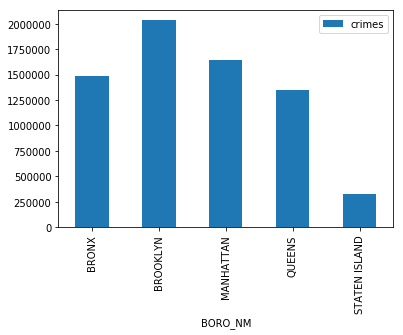

In [18]:
boro_crime.plot.bar()

Download New York geo data.

In [19]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [20]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [21]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Prepare data by neighborhoods.

In [22]:
neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Calculate noeghborhoods count per berough.

In [24]:
br_neig = neighborhoods[['Borough', 'Neighborhood']].groupby(['Borough']).count()
br_neig.rename(columns={'Neighborhood': 'count'}, inplace=True)
br_neig.index = br_neig.index.str.upper()
br_neig

,count
Borough,
BRONX,52
BROOKLYN,70
MANHATTAN,40
QUEENS,81
STATEN ISLAND,63


Lets assume that crimes are equally distributed within a borough. So, calculate anerage crime count per neighborhood.

In [25]:
neighborhoods_crime = pd.DataFrame(columns=['Neighborhood', 'crimes_avg'])
for i, neighborhood_data in neighborhoods.iterrows():        
    neighborhoods_crime = neighborhoods_crime.append({
        'Neighborhood': neighborhood_data['Neighborhood'],
        'crimes_avg': int(round(boro_crime.loc[neighborhood_data['Borough'].upper(), 'crimes'] / br_neig.loc[neighborhood_data['Borough'].upper(), 'count']))
    }, ignore_index=True)

neighborhoods_crime.set_index(['Neighborhood'], inplace=True)

In [26]:
neighborhoods_crime.head()

,crimes_avg
Neighborhood,
Wakefield,28546
Co-op City,28546
Eastchester,28546
Fieldston,28546
Riverdale,28546


In [27]:
neighborhoods_crime.shape

(306, 1)

In [28]:
neighborhoods_crime.describe()

,crimes_avg
count,306
unique,5
top,16684
freq,81


Visualize neighborhoods data.

In [29]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [30]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [31]:
# The code was removed by Watson Studio for sharing.

Foursquare credentials are set


Let's borrow the get_category_type function from the Foursquare lab.

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Obtain venues from Forsquare for each neighborhood.

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
LIMIT = 100
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                         latitudes=neighborhoods['Latitude'],
                         longitudes=neighborhoods['Longitude']
)

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [35]:
print(venues.shape)
venues.head()

(10260, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [36]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,28,28,28,28,28,28
Annadale,8,8,8,8,8,8
Arden Heights,5,5,5,5,5,5
Arlington,7,7,7,7,7,7
Arrochar,19,19,19,19,19,19
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,18,18,18,18,18,18


Let's find out how many unique categories can be curated from all the returned venues

In [37]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 434 uniques categories.


 ## Analyze Each Neighborhood

In [38]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
onehot.drop(columns=['Neighborhood'], inplace=True)

# add neighborhood column back to dataframe
onehot.insert(0, "Neighborhood", venues['Neighborhood'], True)

onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profi

In [39]:
onehot.shape

(10260, 434)

We are interested only in few venue categories. Lets combine same categories and filrer only interesting for us.

In [40]:
categoriels = venues[['Venue Category']]
categoriels = categoriels.replace({'Venue Category': {
    'Athletics & Sports': 'Gym',
    'Gym / Fitness Center': 'Gym',
    'Gymnastics Gym': 'Gym',
    'Drugstore': 'Pharmacy',
    'Garden': 'Park',
    'Garden Center': 'Gym',
}})

onehot = pd.get_dummies(categoriels, prefix="", prefix_sep="")
onehot.drop(columns=['Neighborhood'], inplace=True)
onehot.insert(0, "Neighborhood", venues['Neighborhood'], True)

onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery

In [41]:
onehot.shape

(10260, 428)

In [42]:
onehot = onehot[['Neighborhood', 'Bakery', 'Pharmacy', 'Park', 'Gym', 'Market']]
onehot.head()

,Neighborhood,Bakery,Pharmacy,Park,Gym,Market
0,Wakefield,0,0,0,0,0
1,Wakefield,0,1,0,0,0
2,Wakefield,0,0,0,0,0
3,Wakefield,0,1,0,0,0
4,Wakefield,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Bakery,Pharmacy,Park,Gym,Market
0,Allerton,0.000000,0.035714,0.000000,0.000000,0.000000
1,Annadale,0.125000,0.000000,0.000000,0.000000,0.000000
2,Arden Heights,0.000000,0.200000,0.000000,0.000000,0.000000
3,Arlington,0.000000,0.000000,0.000000,0.000000,0.000000
4,Arrochar,0.000000,0.000000,0.000000,0.052632,0.000000
5,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000
6,Astoria,0.020000,0.000000,0.000000,0.040000,0.000000
7,Astoria Heights,0.076923,0.000000,0.000000,0.000000,0.000000
8,Auburndale,0.000000,0.055556,0.000000,0.111111,0.000000
9,Bath Beach,0.020833,0.062500,0.020833,0.000000,0.000000


Lets combine venues data with crime data.

In [76]:
grouped_full_raw = grouped.join(neighborhoods_crime, on='Neighborhood')
grouped_full_raw

,Neighborhood,Bakery,Pharmacy,Park,Gym,Market,crimes_avg
0,Allerton,0.000000,0.035714,0.000000,0.000000,0.000000,28546
1,Annadale,0.125000,0.000000,0.000000,0.000000,0.000000,5101
2,Arden Heights,0.000000,0.200000,0.000000,0.000000,0.000000,5101
3,Arlington,0.000000,0.000000,0.000000,0.000000,0.000000,5101
4,Arrochar,0.000000,0.000000,0.000000,0.052632,0.000000,5101
5,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,16684
6,Astoria,0.020000,0.000000,0.000000,0.040000,0.000000,16684
7,Astoria Heights,0.076923,0.000000,0.000000,0.000000,0.000000,16684
8,Auburndale,0.000000,0.055556,0.000000,0.111111,0.000000,16684
9,Bath Beach,0.020833,0.062500,0.020833,0.000000,0.000000,29071


In [77]:
grouped_full_raw.shape

(304, 7)

## Cluster Neighborhoods

Crime data should be normalized

In [81]:
grouped_full = grouped_full_raw.copy()
grouped_full["crimes_avg"] = grouped_full[["crimes_avg"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
grouped_full

,Neighborhood,Bakery,Pharmacy,Park,Gym,Market,crimes_avg
0,Allerton,0.000000,0.035714,0.000000,0.000000,0.000000,0.650816
1,Annadale,0.125000,0.000000,0.000000,0.000000,0.000000,0
2,Arden Heights,0.000000,0.200000,0.000000,0.000000,0.000000,0
3,Arlington,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,Arrochar,0.000000,0.000000,0.000000,0.052632,0.000000,0
5,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,0.321536
6,Astoria,0.020000,0.000000,0.000000,0.040000,0.000000,0.321536
7,Astoria Heights,0.076923,0.000000,0.000000,0.000000,0.000000,0.321536
8,Auburndale,0.000000,0.055556,0.000000,0.111111,0.000000,0.321536
9,Bath Beach,0.020833,0.062500,0.020833,0.000000,0.000000,0.66539


In [82]:
grouped_full.shape

(304, 7)

We don't know optimal clusters amount so let's try "Elbow method" to find an optimum

In [83]:
grouped_clustering = grouped_full.drop('Neighborhood', 1)

max_clusters = int(grouped_clustering.shape[0] / 2)
wcss = []

# fit kmeans for various cluster counts 
for kclusters in range (1, max_clusters+1):
    kmeans = KMeans(n_clusters=kclusters).fit(grouped_clustering)
    wcss.append(kmeans.inertia_)

In [84]:
distances = []

# calculate distances
p1 = np.array([1, wcss[0]])
p2 = np.array([max_clusters, wcss[max_clusters-1]])
for i in range(max_clusters):
    p3 = np.array([i, wcss[i]])
    d = np.linalg.norm(np.cross(p2-p1, p3-p1))/np.linalg.norm(p2-p1)
    distances.append(d)

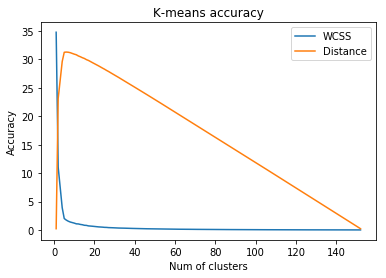

In [85]:
x = np.arange(1, max_clusters + 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Num of clusters')
ax.set_ylabel('Accuracy')
ax.set_title('K-means accuracy')

line1, = ax.plot(x, wcss)
line1.set_label('WCSS')

line2, = ax.plot(x, distances)
line2.set_label('Distance')

ax.legend()

In [87]:
m = max(distances)
n_clusters = distances.index(m) + 1

print('Max distance: {}'.format(m))
print('Optimal cluster number: {}'.format(n_clusters))

Max distance: 31.295770464334286
Optimal cluster number: 6


In [88]:
kmeans = KMeans(n_clusters=n_clusters).fit(grouped_clustering)
kmeans.labels_[0:10]

array([0, 1, 1, 1, 1, 2, 2, 2, 2, 0], dtype=int32)

In [89]:
kmeans.labels_.shape

(304,)

Let's write a function to sort the venues in descending order.

Let's create a new dataframe that includes the cluster as well as venues for each neighborhood

In [181]:
# add clustering labels
grouped_full_labeled = grouped_full.copy()
grouped_full_labeled.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_idx = neighborhoods.set_index('Neighborhood')
neighborhoods_idx = neighborhoods_idx.loc[~neighborhoods_idx.index.duplicated(keep='last')]

merged = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels', 'Bakery', 'Pharmacy', 'Park', 'Gym', 'Market', 'crime_rate'])
for i, data in grouped_full_labeled.iterrows():        
    merged = merged.append({
        'Borough': neighborhoods_idx.loc[data['Neighborhood'], 'Borough'],
        'Neighborhood': data['Neighborhood'],
        'Latitude': neighborhoods_idx.loc[data['Neighborhood'], 'Latitude'],
        'Longitude': neighborhoods_idx.loc[data['Neighborhood'], 'Longitude'],
        'Cluster Labels': data['Cluster Labels'],
        'Bakery': data['Bakery'],
        'Pharmacy': data['Pharmacy'],
        'Park': data['Park'],
        'Gym': data['Gym'],
        'Market': data['Market'],
        'crime_rate': data['crimes_avg']
    }, ignore_index=True)

merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Bakery,Pharmacy,Park,Gym,Market,crime_rate
0,Bronx,Allerton,40.865788,-73.859319,0,0.000,0.035714,0.0,0.000000,0.0,0.650816
1,Staten Island,Annadale,40.538114,-74.178549,1,0.125,0.000000,0.0,0.000000,0.0,0.000000
2,Staten Island,Arden Heights,40.549286,-74.185887,1,0.000,0.200000,0.0,0.000000,0.0,0.000000
3,Staten Island,Arlington,40.635325,-74.165104,1,0.000,0.000000,0.0,0.000000,0.0,0.000000
4,Staten Island,Arrochar,40.596313,-74.067124,1,0.000,0.000000,0.0,0.052632,0.0,0.000000


In [182]:
merged.shape

(304, 11)

In [183]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

In [184]:
for i in range(n_clusters):
    print('Cluyster No. %d' % i)
    
    cluster_data = merged.loc[merged['Cluster Labels'] == i, merged.columns[list(range(5, merged.shape[1]))]]
    display(cluster_data.mean())

Cluyster No. 0


Bakery        0.016969
Pharmacy      0.032072
Park          0.018265
Gym           0.019960
Market        0.001696
crime_rate    0.659247
dtype: float64

Cluyster No. 1


Bakery        0.011877
Pharmacy      0.018296
Park          0.018673
Gym           0.020603
Market        0.002328
crime_rate    0.000000
dtype: float64

Cluyster No. 2


Bakery        0.024609
Pharmacy      0.021834
Park          0.015479
Gym           0.024158
Market        0.004273
crime_rate    0.321536
dtype: float64

Cluyster No. 3


Bakery        0.021606
Pharmacy      0.004812
Park          0.025618
Gym           0.037016
Market        0.001584
crime_rate    1.000000
dtype: float64

Cluyster No. 4


Bakery        0.000000
Pharmacy      0.000000
Park          1.000000
Gym           0.000000
Market        0.000000
crime_rate    0.160768
dtype: float64

Cluyster No. 5


Bakery        0.000000
Pharmacy      0.000000
Park          0.450000
Gym           0.000000
Market        0.000000
crime_rate    0.486176
dtype: float64

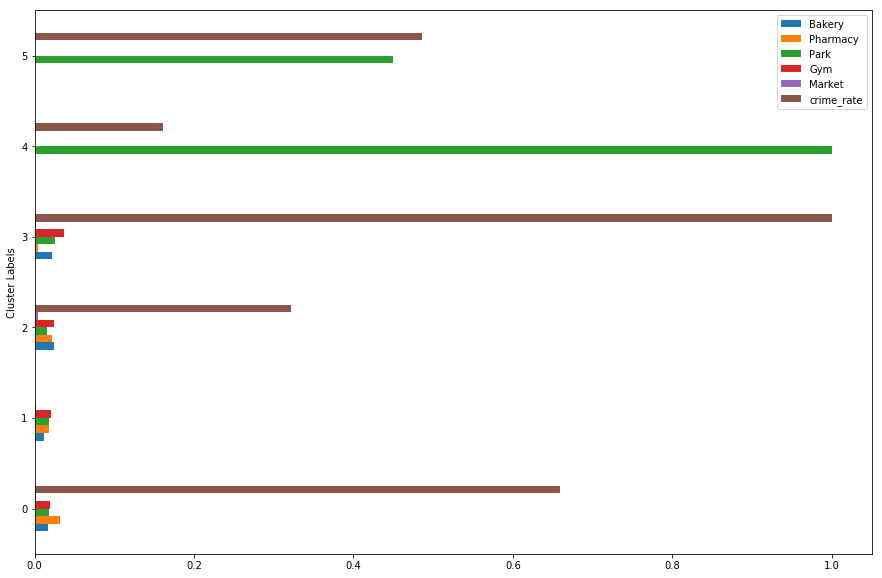

In [185]:
merged_filtered = merged.loc[:, merged.columns[[4] + list(range(5, merged.shape[1]))]].copy()
merged_filtered.fillna(0, inplace=True)
merged_filtered_grouped = merged_filtered.groupby('Cluster Labels').mean()
merged_filtered_grouped.plot.barh(figsize=(15, 10))

Lets assume thayt the most attractive cluster in cluster No. 1. Lets allpy additional data filtering and visualize a result.

In [186]:
cluster1_data = merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0, 1, 2, 3] + list(range(5, merged.shape[1]))]].drop_duplicates()
cluster1_data

,Borough,Neighborhood,Latitude,Longitude,Bakery,Pharmacy,Park,Gym,Market,crime_rate
1,Staten Island,Annadale,40.538114,-74.178549,0.125000,0.000000,0.000000,0.000000,0.000000,0.0
2,Staten Island,Arden Heights,40.549286,-74.185887,0.000000,0.200000,0.000000,0.000000,0.000000,0.0
3,Staten Island,Arlington,40.635325,-74.165104,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Staten Island,Arrochar,40.596313,-74.067124,0.000000,0.000000,0.000000,0.052632,0.000000,0.0
13,Staten Island,Bay Terrace,40.553988,-74.139166,0.021277,0.021277,0.000000,0.000000,0.000000,0.0
27,Staten Island,Bloomfield,40.605779,-74.187256,0.000000,0.000000,0.200000,0.000000,0.000000,0.0
39,Staten Island,Bulls Head,40.609592,-74.159409,0.000000,0.042553,0.000000,0.021277,0.000000,0.0
41,Staten Island,Butler Manor,40.506082,-74.229504,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
47,Staten Island,Castleton Corners,40.613336,-74.119181,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
49,Staten Island,Charleston,40.530531,-74.232158,0.031250,0.000000,0.000000,0.031250,0.000000,0.0


Lets filter neighborhooods with present Park and Market.

In [187]:
cluster1_data_filtered = cluster1_data[ cluster1_data['Park'] > 0 ]
cluster1_data_filtered = cluster1_data_filtered[ cluster1_data_filtered['Market'] > 0 ]
cluster1_data_filtered

,Borough,Neighborhood,Latitude,Longitude,Bakery,Pharmacy,Park,Gym,Market,crime_rate
51,Staten Island,Chelsea,40.594726,-74.189560,0.056604,0.0,0.009434,0.009434,0.018868,0.0
266,Staten Island,Sunnyside,40.612760,-74.097126,0.041667,0.0,0.020833,0.041667,0.020833,0.0


In [188]:
# create map of New York using latitude and longitude values
map_cluster1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(cluster1_data_filtered['Latitude'], cluster1_data_filtered['Longitude'], cluster1_data_filtered['Borough'], cluster1_data_filtered['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster1)  
    
map_cluster1